# Прогнозирование количества заказов такси

## Введение

#### Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

#### Задача проекта
Разработать модель, которая сможет спрогнозировать количество заказов такси на следующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

#### Описание данных
- В нашем распоряжении один входной признак - `'datetime'`, в столбце содержится информаци о дате и времени
- Целевой признак - `'orders'`, содержит целые числа - количество заказов в промежуток `'datetime'`

#### Порядок действий
1. Загрузить данные, проверить на соответствие с описанием
2. Провести предобработку данных
3. Провести исследовательский анализ данных
4. Добавить новые признаки
5. Обучить модели МО, подобрать лучшие гиперпараметры
6. Оформить вывод по итогам работы

## Загрузка и первоначальное изучение данных

In [1]:
# Библиотеки
#!pip install phik -q
#!pip install lightgbm -q
#!pip install scikit-learn==1.4 -q
#!pip install matplotlib -q
#!pip install seaborn==0.11.1 -q

In [2]:
# Необходимые импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import phik

from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, TimeSeriesSplit)

from sklearn.preprocessing import (
    StandardScaler, OrdinalEncoder, OneHotEncoder)
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose


Bad key text.latex.preview in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_qualit

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


#### Вывод по первоначальному изучению данных
- Данные соответствуют описанию
- В данных отсутствуют пропуски
- Тип данных столбца `'datetime'` должен быть изменен на **datetime**

## Предобработка данных

Так как в данных отсутствуют пропуски, можем переходить сразу к обработке дубликатов, но перед этим обработаем тип данных `'datetime'`.

### Обработка типов данных

Необходимо перевести `'datetime'` в тип данных datetime.

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Типы данных оптимальны, двигаемся дальше.

### Обработка дубликатов

In [7]:
if (data.duplicated().sum()) == 0:
    print('Явные дубликаты отсутствуют')
else:
    print(f'Количество явных дубликатов равно {data.duplicated().sum()}')

Явные дубликаты отсутствуют


Так как у нас всего один входной признак, и он представлен в виде временных промежутков, то наличие неявных дубликатов можно проверить, сравнив количество его уникальных значений с количеством строк, при их отсутствии оно должно совпадать. Рассмотрим также случай, когда в данных попались неявные дубликаты, устранить их можно, построив сводную таблицу и сгруппировав данные по `'datetime'`.

Также сразу поместим `'datetime'` в индекс таблицы.

In [8]:
if (len(data['datetime'].unique()) == len(data['datetime'])) == True:
    print('Неявные дубликаты отсутствуют')
    data = data.set_index('datetime')
else:
    print('Обнаружены неявные дубликаты')
    data = data.pivot_table(index='datetime', values='orders', aggfunc='sum')
    print('Неявные дубликаты устранены')

Неявные дубликаты отсутствуют


Можно двигаться дальше.

### Ресэмплинг

Так как нам необходимо прогнозировать количество заказов на каждый час, необходимо провести ресэмплинг.

In [9]:
data = data.resample('1h').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные приведены к нужному формату

#### Общий вывод по Предобработке
- Пропущенные значения отсутствуют
- Дубликаты отсутствуют
- Типы данных оптимальны
- `'datetime'` теперь индекс таблицы
- Проведен ресэмплинг: `'datetime'` теперь содержит данные в разрезе часа

## Исследовательский анализ данных

Изучим распределение наших данных, тренд, сезонность в разрезе недели, в разрезе двух дней и остатки.

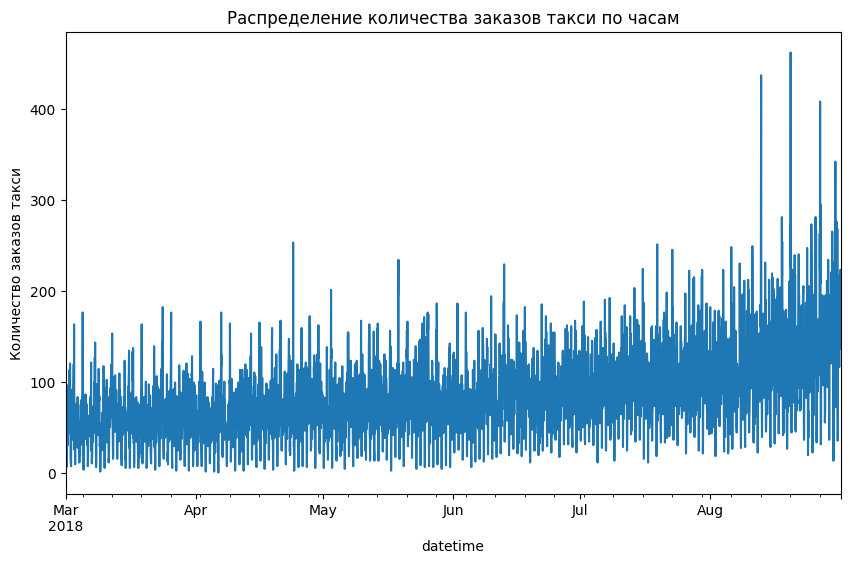

In [10]:
data.plot(figsize=(10,6), legend=False)
plt.title('Распределение количества заказов такси по часам')
plt.ylabel('Количество заказов такси')
plt.show()

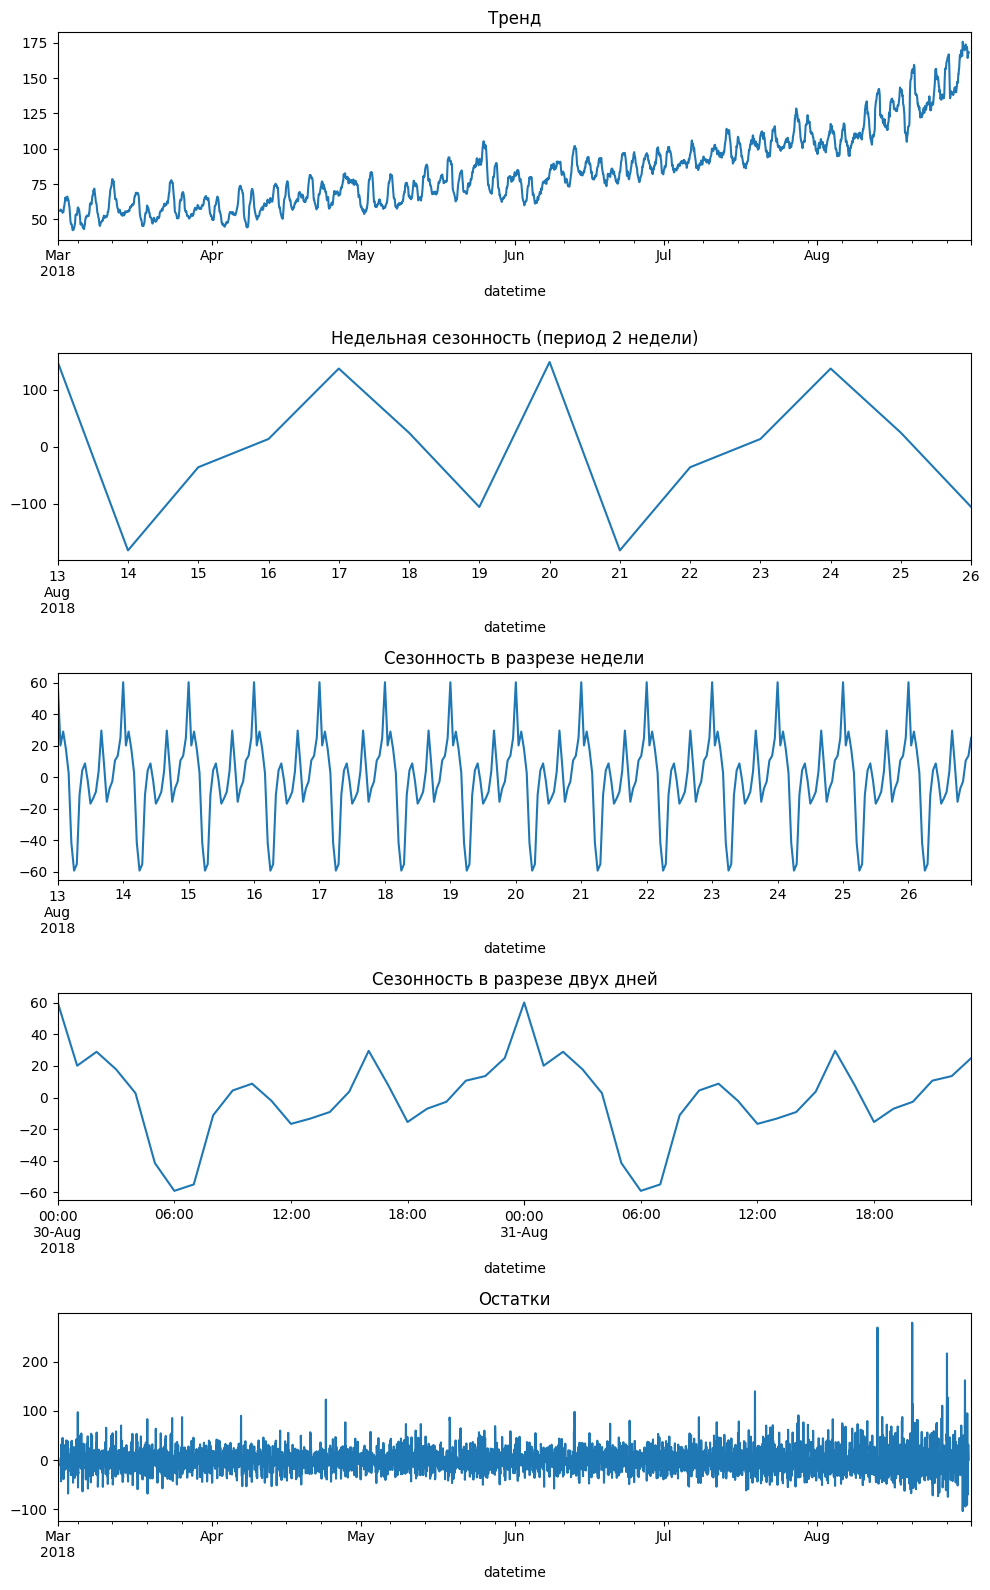

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 16))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(512)
seasonal_decompose(data.resample('1D').sum()).seasonal['2018-08-13':'2018-08-26'].plot(ax=plt.gca())
plt.title('Недельная сезонность (период 2 недели)')

plt.subplot(513)
decomposed.seasonal['2018-08-13':'2018-08-26'].plot(ax=plt.gca())
plt.title('Сезонность в разрезе недели')

plt.subplot(514)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность в разрезе двух дней')

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

#### Интерпретация графиков (вывод по Исследовательскому анализу данных):
- В нашем распоряжении данные о заказах такси с марта 2018 по август 2018
- Тренд восходящий, количество заказов такси растет во всех промежутках, более интенсивный рост начинается в июне 2018
- Присутствует сезонность в разрезе дня: максимальное количество заказов ночью - около 00:00 каждый день, после чего начинается резкий спад до минимального значения - с 6 до 7 утра. Количество заказов растет с 6 утра до 11 (локальный пик 1), с 12:00 до 16:00 (локальный пик 2), после 18:00 начинается рост количества заказов и заканчивается он в глобальном пике (00:00).
- Присутствует недельная сезонность: максимальное количество заказов такси - в понедельник, во вторник - минимальное, за которым следует рост (среда-пятница), в пятницу наблюдается второе максимальное количество заказов, за которым следует спад в субботу и воскресенье, а далее резки рост до значения понедельника.

## Добавление новых признаков

Чтобы модель более гибко обучалась на тренировочных данных, необходимо разбить `'datetime'` на несколько признаков, а именно: 
- Месяц
- День
- Время (час)
- Количество заказов 1 день назад (так как присутствует сезонность в разрезе дня)
- Скользящее среднее

In [12]:
# Функция для автоматического создания признаков
def make_features(data):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, 169):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(168).mean()

make_features(data) 

# Создание признаков создало нам несколько строк с пропусками, очистим данные от них
data = data.dropna()

/var/folders/m0/94b7zrt17lv3szp310d4y2bh0000gn/T/ipykernel_71154/567832323.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{lag}'] = data['num_orders'].shift(lag)
/var/folders/m0/94b7zrt17lv3szp310d4y2bh0000gn/T/ipykernel_71154/567832323.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'lag_{lag}'] = data['num_orders'].shift(lag)
/var/folders/m0/94b7zrt17lv3szp310d4y2bh0000gn/T/ipykernel_71154/567832323.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

#### Вывод по созданию признаков:
Созданы следующие признаки для обучения модели:
- День недели
- Час
- Количество заказов за прошлую неделю (каждый час, 168ч)
- Скользящее среднее за неделю (168ч)

## Обучение моделей

Для обучения моделей будем использовать пайплайн и рандомизированный поиск гиперпараметров

### Поиск лучшей модели

In [13]:
# Списки переменных
num_list = data.drop(['num_orders', 'day_of_week', 'hour'], axis=1).columns
cat_list = ['day_of_week', 'hour']

In [14]:
# Словарь гиперпараметров для моделей
params = [
    {
        'models': [DecisionTreeRegressor()],
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 5),
        'models__max_depth': range(2, 8)
    },
    {
        'models': [LGBMRegressor(n_estimators=200)],
        'models__max_depth': range(2, 4),
        'models__num_leaves': range(2, 4),
        'models__min_split_gain': range(2, 6)
    },
    {
        'models': [LinearRegression()],
        # Для линейной регрессии закодируем категориальные признаки с помощью OHE
        'preprocessor__cat': [Pipeline(
            [
                ('ohe', OneHotEncoder(drop='first'))
            ]
        )]
    }
]

In [15]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('num_orders', axis=1),
    data['num_orders'],
    test_size=0.1,
    shuffle=False
)

In [16]:
# Для обучения моделей будем использовать функцию
def learn_model(params):

    # Пайплайн для обработки признаков и обучения модели
    data_preprocessor = ColumnTransformer(
        [
            ('cat', 'passthrough', cat_list),
            ('num', StandardScaler(), num_list)
        ],
        remainder='passthrough'
    )

    final_pipe = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', DecisionTreeRegressor())
        ]
    )

    # Для использования кросс-валидации для временных рядов, используем TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Поиск лучшей модели
    search = RandomizedSearchCV(
        final_pipe,
        params,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    search.fit(X_train, y_train)

    print(f'Лучшая модель: {search.best_estimator_}')

    # Вывод метрик
    print(
        f'Метрика RMSE на тренировочной выборке: {root_mean_squared_error(y_train, search.best_estimator_.predict(X_train))}')
    print(
        f'Лучшая RMSE при кросс-валидации: {abs(search.best_score_)}')

    return search.best_estimator_

In [17]:
np.random.seed(42)
estimator = learn_model(params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31586
[LightGBM] [Info] Number of data points in the train set: 3823, number of used features: 171
[LightGBM] [Info] Start training from score 79.561601
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', 'passthrough',
                                                  ['day_of_week', 'hour']),
                                                 ('num', StandardScaler(),
                                                  Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10',
       ...
       'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag_164', 'lag_165',
       'lag_166', 'lag_167', 'lag_168', 'rolling_mean'],
      dtype='object', length=

Лучшая модель найдена, можно переходить к проверке модели на тестовой выборке.

### Проверка лучшей модели на тестовой выборке

In [18]:
print(
    f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, estimator.predict(X_test))}')

Метрика RMSE на тестовой выборке: 37.42460424649313


RMSE на тестовой выборке чуть меньше 37.5.

Проведем оценку адекватности предсказаний модели, для этого предскажем на тестовой выборке количество заказов средним значением количества заказов на тренировочной выборке.

In [19]:
# Предсказание заказов средним по трен. выборке
train_mean_orders_num = y_train.mean()
mean_prediction = np.ones(len(y_test)) * train_mean_orders_num
mean_prediction_rmse = root_mean_squared_error(y_test, mean_prediction)
print(
    f'RMSE при предсказании средним по тренировочной выборке: {mean_prediction_rmse}')

RMSE при предсказании средним по тренировочной выборке: 84.45113423436631


Необходимое для заказчика значение метрики RMSE достигнуто, модель дает адекватные оценки, разница с предсказанием средним чуть меньше 50 заказов, это существенная разница.

### Объяснение результатов

Изучим, какие признаки имели большее влияние на результат работы модели

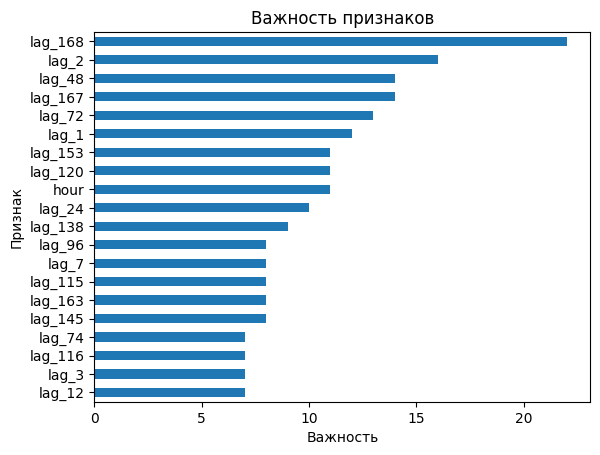

In [20]:
# Найдем важность признаков и построим график
report = pd.DataFrame(columns=['feature', 'value'])  
report['feature'] = estimator.feature_names_in_
report['value'] = estimator.steps[1][1].feature_importances_
report = report.sort_values(by='value', ascending=True).set_index('feature').tail(20)

report.plot(kind='barh', legend=False)
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

#### Анализ важности признаков
- Сильнее всего на количество заказов такси влияет количество заказов в тот же день неделю назад, также значительно влияет час

#### Общий вывод по обучению моделей МО
- Найдена лучшая модель для предсказания количества заказов такси, это бустинг LightGBM, ее показатель на тестовой выборке метрика RMSE=37.5
- Сильнее всего на количество заказов такси влияет количество заказов в тот же день неделю назад, также значительно влияет час

## Общий вывод по проекту
- По итогам предобработки тип данных колонки `'datetime'` приведен к оптимальному. Проведен ресэмплинг выборки: итоговая таблица содержит информацию о количестве заказоа такси в разрезе каждого часа.
- Исследовано распределение количества заказов в зависимости от даты и времени. Исследован тренд изменения количества заказов такси: он восходящий, количество заказов такси растет во всех промежутках, более интенсивный рост начинается в июне 2018.
- Присутствует сезонность в разрезе дня: максимальное количество заказов ночью - около 00:00 каждый день, после чего начинается резкий спад до минимального значения - с 6 до 7 утра. Количество заказов растет с 6 утра до 11 (локальный пик 1), с 12:00 до 16:00 (локальный пик 2), после 18:00 начинается рост количества заказов и заканчивается он в глобальном пике (00:00). В разрезе 2 обозреваемых недель сезонность сохраняется, каждый день количество заказов меняется циклично.
- Присутствует недельная сезонность: максимальное количество заказов такси - в понедельник, во вторник - минимальное, за которым следует рост (среда-пятница), в пятницу наблюдается второе максимальное количество заказов, за которым следует спад в субботу и воскресенье, а далее резки рост до значения понедельника.
- Добавлены новые признаки для обучения моделей МО:
    - День недели
    - Час
    - Количество заказов каждый час за всю прошлую неделю (168ч)
    - Скользящее среднее за неделю (168ч)
- Найдена лучшая модель для предсказания количества заказов такси: бустинг LightGBM с подобранными гиперпараметрами. Ее результат: RMSE на тестовой выборке 37.5, показатель удовлетворяет запросу заказчика.
- Исследовано влияние признаков на результат прогнозирования количества заказов такси. Сильнее всего на количество заказов такси влияет количество заказов в тот же день неделю назад, также значительно влияет час

## Рекомендации для заказчика
- По итогам работы обучена модель, которая способна прогнозировать количество заказов такси на следующий час, рекомендуем ее к использованию для привлечения водителей в период пиковой нагрузки.